# Convolutional LSTM for action prediction

- keep track of best validation value + Save checkpoints with information (autosave)
- clean naming (of how models are saved, configs are saved, runs are called)
- confusion matrix of result / comparison with baseline LSTM (that only takes in actions)
- wandb/ tensorboard integration (also for gradient information?)
- hydra integration for hyperparameters?

### Hyperparameters

In [1]:
# preprocessing
seq_length = 20
training_set_size = 0.67

# lstm configuration
input_size = 960
hidden_size = 20
num_layers = 1
num_classes = 4

# training
num_epochs = 2000
learning_rate = 0.01

### Imports

In [2]:
import pickle
import hydra
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from tqdm.auto import tqdm

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


### Load datasets

In [3]:
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

### Preprocess data

In [5]:
def sliding_windows(dataset, seq_length, hot_encoding=True):    
    x_actions = []
    y_actions = []

    actions = dataset['actions']
    imgs = dataset['observations']
    
    # preprocess actions
    actions = [[i] for i in actions]
    
    # preprocess images
    x_imgs = []
    for img in imgs:
        img = torch.from_numpy(img).float()
        img = img.permute(2, 0, 1)
        x_imgs.append(img)
    x_imgs_processed = torch.stack(x_imgs)
    
    # actual sliding window
    x_imgs = []
    for i in range(len(actions)-seq_length-1):
        _x_actions = actions[i:(i+seq_length)]
        _x_imgs = x_imgs_processed[i:(i+seq_length)]
        _y_actions = actions[i+1+seq_length] # _y = data[i+seq_length]
        
        x_actions.append(_x_actions)
        x_imgs.append(_x_imgs)
        y_actions.append(_y_actions)
        
    x_imgs = torch.stack(x_imgs)
    
    if hot_encoding:
        
        adopted = []
        for values in y_actions:
            #for value in values:
            val = np.eye(4)[values[0]]
            adopted.append(val)
        y_actions = adopted

    return np.array(x_actions), x_imgs, np.array(y_actions) # train, val. data

x_acts, x_imgs, y_acts = sliding_windows(oracle_data, seq_length)

In [6]:
from torch.autograd import Variable

train_size = int(len(y_acts) * training_set_size)
test_size = len(y_acts) - train_size

# (full) data set
dataX_acts = Variable(torch.Tensor(np.array(x_acts)))
dataX_imgs = Variable(torch.Tensor(x_imgs))
dataY_acts = Variable(torch.Tensor(np.array(y_acts)))

# training set
trainX_acts = Variable(torch.Tensor(np.array(x_acts[0:train_size])))
trainX_imgs = Variable(torch.Tensor(np.array(x_imgs[0:train_size])))
trainY_acts = Variable(torch.Tensor(np.array(y_acts[0:train_size])))

# validation set
testX_acts = Variable(torch.Tensor(np.array(x_acts[train_size:len(x_acts)])))
testX_imgs = Variable(torch.Tensor(np.array(x_imgs[train_size:len(x_imgs)])))
testY_acts = Variable(torch.Tensor(np.array(y_acts[train_size:len(y_acts)])))

In [51]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(hidden_size, int(hidden_size*0.5))
        self.fc2 = nn.Linear(int(hidden_size*0.5), num_classes)

    def forward(self, x):
        # newly initialized only after each epoch
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = F.relu(self.fc1(h_out))
        out = self.fc2(out)
        
        return out

In [52]:
class CNN(nn.Module):
    
    def __init__(self, seq_length):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, seq_length, 5)
        self.conv2 = nn.Conv2d(seq_length, seq_length*2, 5)
        self.conv3 = nn.Conv2d(seq_length*2, seq_length*3, 5)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, i):
        x = i.reshape(-1, i.shape[2], i.shape[3], i.shape[4]) # merges batch and length dimension
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(i.shape[0], i.shape[1], -1)
        
        return x

In [53]:
input_size = 960

cnn = CNN(seq_length)
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

features = cnn(trainX_imgs)
outputs = lstm(features)

print('CNN input shape:', trainX_imgs.size())
print('CNN output shape:', features.size())

print('LSTM input shape:', features.size())
print('LSTM output shape:', outputs.size())

print('Label shape:', trainY_acts.size())

CNN input shape: torch.Size([786, 20, 3, 32, 32])
CNN output shape: torch.Size([786, 20, 960])
LSTM input shape: torch.Size([786, 20, 960])
LSTM output shape: torch.Size([786, 4])
Label shape: torch.Size([786, 4])


### Network training

In [72]:
# only actions as input

input_size = 1
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.BCEWithLogitsLoss() # MSELoss - regression, CrossEntropyLoss for labels
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# full batch training likely is too slow!
for epoch in range(num_epochs):
    outputs = lstm(trainX_acts)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY_acts)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 200 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.78522
Epoch: 200, loss: 0.13175
Epoch: 400, loss: 0.09460
Epoch: 600, loss: 0.08001
Epoch: 800, loss: 0.07675
Epoch: 1000, loss: 0.07609
Epoch: 1200, loss: 0.07630
Epoch: 1400, loss: 0.07558
Epoch: 1600, loss: 0.07542
Epoch: 1800, loss: 0.07535


In [ ]:
# only imgs as input

input_size = 1
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss() # MSELoss - regression, CrossEntropyLoss for labels
#params = list(cnn.parameters()) + list(lstm.parameters())
#optimizer = torch.optim.Adam(params, lr=learning_rate)
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# full batch training likely is too slow!
for epoch in range(num_epochs):
    #features = net_cnn(trainX_imgs)
    #features = features #+ 0.01*trainX_acts
    features = trainX_acts
    outputs = lstm(features)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY_acts)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 200 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

### Plotting results

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

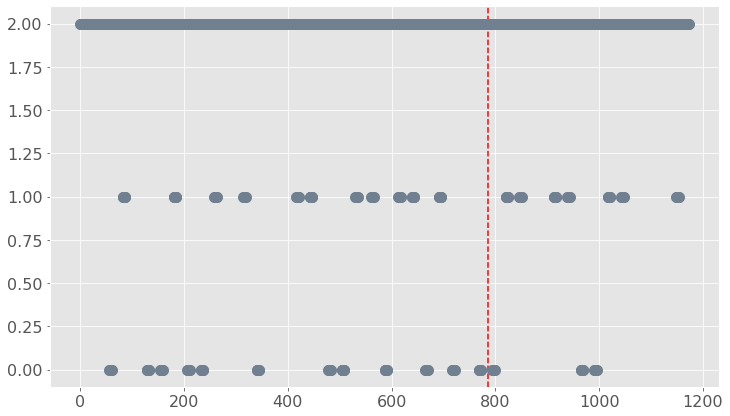

In [100]:
from matplotlib import pyplot as plt

lstm.eval()
train_predict = lstm(dataX_acts)

t = Variable(torch.Tensor([0]))  # threshold
train_predict = (train_predict > t).float() * 1

data_predict = train_predict.data.numpy()
dataY_plot = dataY_acts.data.numpy()

#for data in 

# to-do: reverse one hot encoding !!
with plt.style.context('ggplot'):
    plt.figure(figsize=(12, 7))
    plt.rcParams.update({'font.size': 16})
    plt.axvline(x=train_size, c='r', linestyle='--')

    plt.plot(new_dataY_plot, 'o', color='slategray', markersize=10, label="sine")
    plt.plot(new_data_predict, 'o', markersize=5, label="cos")
    
    plt.legend(loc="lower right")
    plt.title('Action sequence prediction')
    plt.xlabel('Sequence')
    plt.ylabel('Action')
    plt.show()

In [139]:
for val in train_predict:
    print(val)

tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])


tensor([0., 0., 1., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 1., 0., 0.])
tensor([0., 1., 0., 0.])
tensor([0., 1., 0., 0.])
tensor([0., 1., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([1., 0., 0., 0.])
tensor([1., 0., 0., 0.])
tensor([1., 0., 0., 0.])
tensor([1., 0., 0., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])
tensor([0., 0., 1., 0.])


In [136]:
print('length data_predict', len(data_predict))
print('length dataY_plot', len(dataY_plot))

print(data_predict[0][0])
print(dataY_plot[0][0])

print('data_predict', data_predict)
print('dataY_plot', dataY_plot)


data_predict = data_predict.astype(int)
print('type data_predict', type(data_predict))
print('type dataY_plot', type(dataY_plot))

new_data_predict = [np.where(r==1)[0] for r in data_predict]
new_dataY_plot = [np.where(r==1)[0][0] for r in dataY_plot]

print('type data_predict', type(new_data_predict))
print('type dataY_plot', type(new_dataY_plot))

print(new_data_predict)
print(new_dataY_plot)

length data_predict 1174
length dataY_plot 1174
0
0.0
data_predict [[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 ...
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]]
dataY_plot [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
type data_predict <class 'numpy.ndarray'>
type dataY_plot <class 'numpy.ndarray'>
type data_predict <class 'list'>
type dataY_plot <class 'list'>
[array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([], dtype=int64), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([2]), array([

In [138]:
for i in new_data_predict:
    print(int(i))

2
2
2
2
2
2


TypeError: only size-1 arrays can be converted to Python scalars

### Initialize models

In [ ]:
# https://stackoverflow.com/questions/52138290/how-can-we-define-one-to-one-one-to-many-many-to-one-and-many-to-many-lstm-ne

# enable model to work with different sequence lengths
# wandb and tensorboard integration

# write model summary into runs folder

### Tensorboard integrations

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
# hydra integration for hyperparameters
import hydra
from omegaconf import OmegaConf
import datetime


hydra.core.global_hydra.GlobalHydra.instance().clear()

hydra.initialize(version_base=None, config_path='conf') # Assume the configuration file is in the current folder
cfg = hydra.compose(config_name='config')

print(cfg)
print(cfg.params.lr)

print(OmegaConf.to_yaml(cfg))

local_time = str(datetime.datetime.now().isoformat())
name = local_time + '_configs'
OmegaConf.save(cfg, "runs/"+name)

### Train model

In [ ]:
# track best validation value
# save model during training

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in DualInput_model.state_dict():
    print(param_tensor, "\t", DualInput_model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("\nOptimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

### Plot loss and accuracy curves

In [ ]:
# look into confusion matrix